# **CS 1810 Homework 4**
---
To account for potential version issues, try the following in your terminal:

1. Create a new environment with `python3 -m venv venv`
2. Activate that environment with `source venv/bin/activate`
3. Make sure the interpreter in the top right corner of your VSCode (or whatever you use to run your code is venv).
4. If you get a "install kernel" message, press it.
5. Run `pip install -r requirements.txt`
6. Run the remainder of this notebook.

Note that this is not necessary but can help prevent any issues due to package versions.

**The following notebook is meant to help you work through Problem 2 on Homework 4. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
from scipy.spatial import distance

# Problem 1

In [2]:
# YOUR CODE HERE
np.random.seed(42)

pass

# Problem 2

In [3]:
# Loading datasets

small_dataset = np.load("data/small_dataset.npy")
small_labels = np.load("data/small_dataset_labels.npy").astype(int)
large_dataset = np.load("data/large_dataset.npy")

## K-Means

In [4]:
class KMeans(object):
    # K is the K in KMeans
    def __init__(self, K):
        self.K = K

    # Helper functions
    def _initialize_centroids(self, X):
        indices = np.random.choice(X.shape[0], self.K, replace=False)
        return X[indices]

    def _assign_clusters(self, X, centroids):
        # Compute distances between each point and each centroid
        dists = np.linalg.norm(X[:, None] - centroids, axis=2)
        return np.argmin(dists, axis=1)

    def _update_centroids(self, X, assignments):
        centroids = np.zeros((self.K, X.shape[1]))
        for k in range(self.K):
            if np.any(assignments == k):
                centroids[k] = X[assignments == k].mean(axis=0)
            else:
                centroids[k] = X[np.random.choice(X.shape[0])]
        return centroids

    def _compute_objective(self, X, centroids, assignments):
        obj = 0.0
        for k in range(self.K):
            cluster_points = X[assignments == k]
            if cluster_points.shape[0] > 0:
                obj += np.sum((cluster_points - centroids[k]) ** 2)
        return obj

    def fit(self, X):
        """
        Run the k-Means algorithm for exactly 10 iterations.

        :param X: a (N x 784) array since the dimension of each image is 28x28
        """
        self.objectives = []
        self.centroids = self._initialize_centroids(X)
        for i in range(10):
            self.assignments = self._assign_clusters(X, self.centroids)
            self.centroids = self._update_centroids(X, self.assignments)
            obj = self._compute_objective(X, self.centroids, self.assignments)
            self.objectives.append(obj)

    def plot_verify_objective(self):
        """
        This should plot the objective as a function of iteration and verify that it never increases.
        This assumes that fit() has already been called.
        """
        plt.figure()
        plt.plot(self.objectives, marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('Objective (Residual Sum of Squares)')
        plt.title('K-means Objective over Iterations')
        plt.show()

    def get_mean_images(self):
        """ 
        Return the arrays for K images, each representing the mean of the fitted clusters.
        """
        return self.centroids

    def get_cluster_sizes(self):
        sizes = np.zeros(self.K, dtype=int)
        for k in range(self.K):
            sizes[k] = np.sum(self.assignments == k)
        return sizes


### Part 1

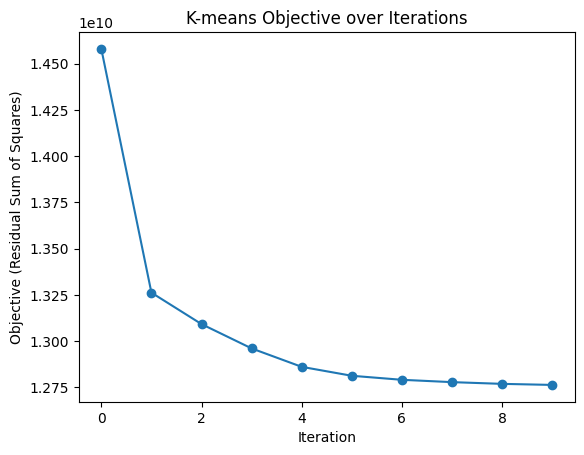

In [5]:
KMeansClassifier = KMeans(K=10)
KMeansClassifier.fit(large_dataset)
KMeansClassifier.plot_verify_objective()

### Code for plots in part 2 and 3

In [6]:
def make_mean_image_plot(data, standardized = False, filename=None):
    niters = 3
    K = 10
    allmeans = np.zeros((K, niters, 784))
    for i in range(niters):
        KMeansClassifier = KMeans(K=K)
        KMeansClassifier.fit(data)
        allmeans[:,i] = KMeansClassifier.get_mean_images()
    fig = plt.figure(figsize=(10,10))
    plt.suptitle('Class mean images across random restarts' + (' (standardized data)' if standardized else ''), fontsize=16)
    for k in range(K):
        for i in range(niters):
            ax = fig.add_subplot(K, niters, 1+niters*k+i)
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='both', which='both', length=0)
            if k == 0: plt.title('Iter '+str(i))
            if i == 0: ax.set_ylabel('Class '+str(k), rotation=90)
            plt.imshow(allmeans[k,i].reshape(28,28), cmap='Greys_r')
    if filename:
        plt.savefig(f'img_output/{filename}') 
    plt.show()

### Part 2

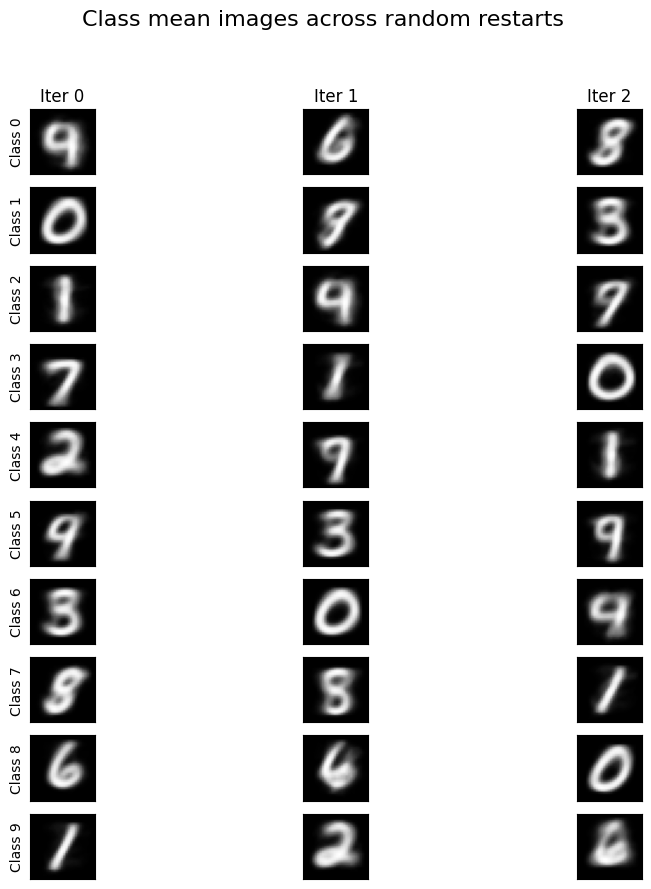

In [8]:
import os
os.makedirs('img_output', exist_ok=True)
make_mean_image_plot(large_dataset, filename='p2.2.png')


### Part 3

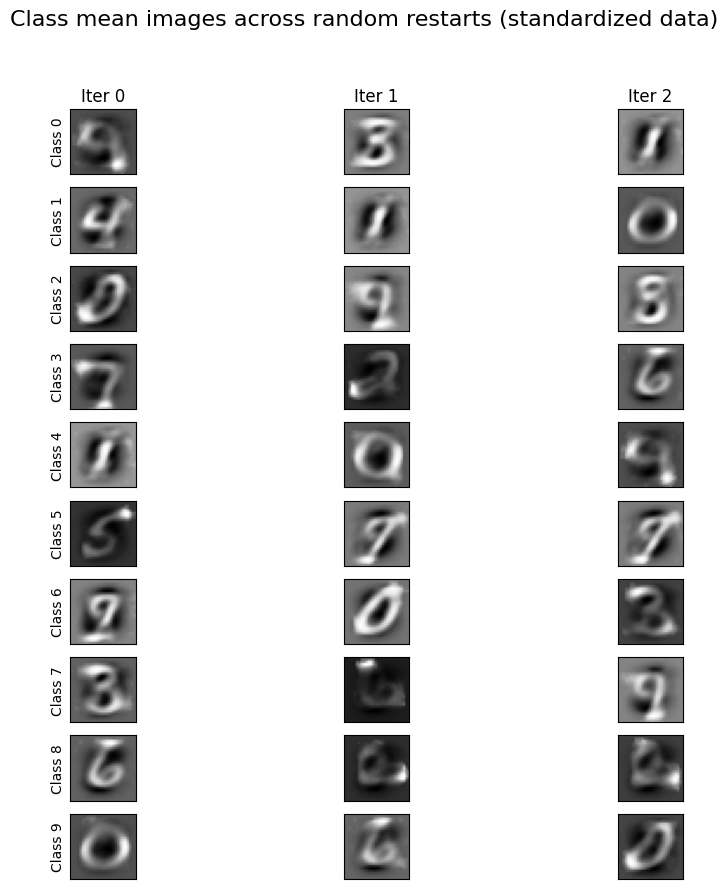

In [9]:
# Replace this
large_dataset_std = (large_dataset - np.mean(large_dataset, axis=0)) / np.where(np.std(large_dataset, axis=0) == 0, 1, np.std(large_dataset, axis=0))


make_mean_image_plot(large_dataset_std, standardized = True, filename='p2.3.png')

## HAC: Part 4


In [10]:
class HAC(object):
    def __init__(self, linkage):
        self.linkage = linkage

    def fit(self, X):
        self.X = X
        self.history = {}
        clusters = [[i] for i in range(X.shape[0])]
        self.history[len(clusters)] = clusters.copy()
        while len(clusters) > 1:
            best = np.inf
            best_pair = None
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    if self.linkage == 'min':
                        d = np.min(distance.cdist(self.X[clusters[i]], self.X[clusters[j]], 'euclidean'))
                    elif self.linkage == 'max':
                        d = np.max(distance.cdist(self.X[clusters[i]], self.X[clusters[j]], 'euclidean'))
                    elif self.linkage == 'centroid':
                        centroid_i = np.mean(self.X[clusters[i]], axis=0)
                        centroid_j = np.mean(self.X[clusters[j]], axis=0)
                        d = np.linalg.norm(centroid_i - centroid_j)
                    else:
                        raise ValueError("Unknown linkage type")
                    if d < best:
                        best = d
                        best_pair = (i, j)
            i, j = best_pair
            new_cluster = clusters[i] + clusters[j]
            # Remove clusters in reverse order to avoid index shifting
            clusters.pop(j)
            clusters.pop(i)
            clusters.append(new_cluster)
            self.history[len(clusters)] = clusters.copy()
        self.clusters_full = self.history

    def get_k_clusters(self, K):
        return self.history[K]

    def get_mean_images(self, K):
        clusters = self.get_k_clusters(K)
        means = []
        for cluster in clusters:
            mean_img = np.mean(self.X[cluster], axis=0)
            means.append(mean_img)
        return np.array(means)

    def get_cluster_sizes(self, K):
        clusters = self.get_k_clusters(K)
        sizes = [len(cluster) for cluster in clusters]
        return sizes


### Part 4: This takes ~6 minutes to run

Done: max
Done: min
Done: centroid


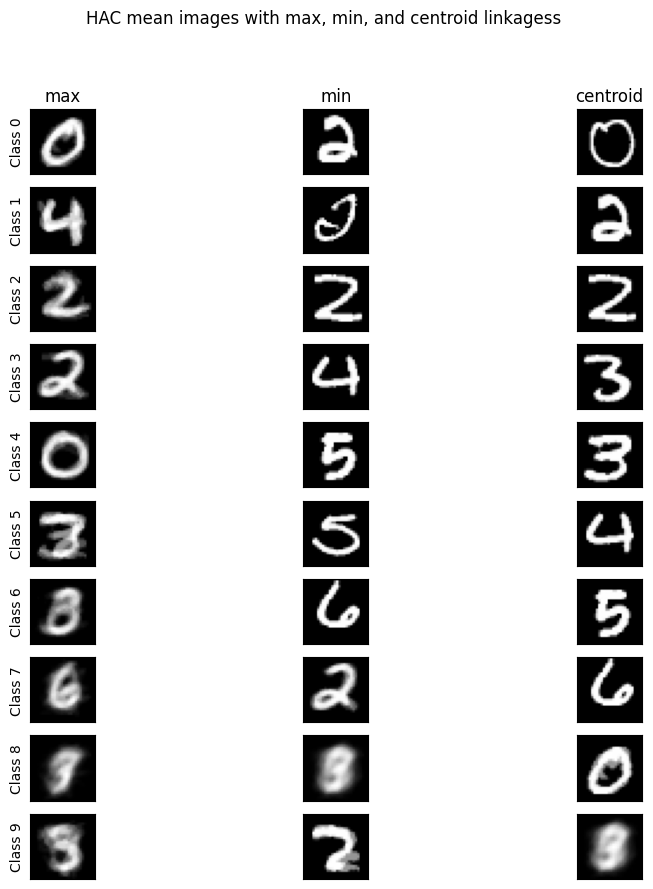

In [11]:
LINKAGES = [ 'max', 'min', 'centroid' ]
n_clusters = 10
cluster_sizes = []

fig = plt.figure(figsize=(10,10))
plt.suptitle("HAC mean images with max, min, and centroid linkagess")
for l_idx, l in enumerate(LINKAGES):
    # Fit HAC
    hac = HAC(l)
    hac.fit(small_dataset)
    mean_images = hac.get_mean_images(n_clusters)
    cluster_sizes.append(hac.get_cluster_sizes(n_clusters)) # used in Part 8, append here to avoid re-fitting
    # Make plot
    for m_idx in range(mean_images.shape[0]):
        m = mean_images[m_idx]
        ax = fig.add_subplot(n_clusters, len(LINKAGES), l_idx + m_idx*len(LINKAGES) + 1)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        if m_idx == 0: plt.title(l)
        if l_idx == 0: ax.set_ylabel('Class '+str(m_idx), rotation=90)
        plt.imshow(m.reshape(28,28), cmap='Greys_r')
    print("Done:", l)
plt.savefig('img_output/p2.4.png') 
plt.show()

### Part 5:

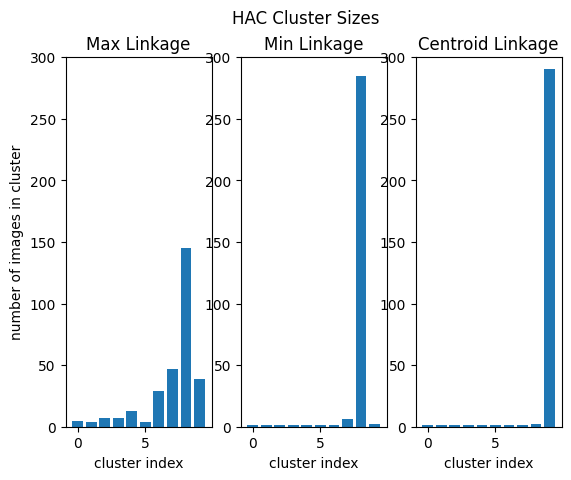

In [13]:
# HAC graphs
def plot_cluster_sizes(n_clusters, cluster_sizes, filename=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("HAC Cluster Sizes")
    ax1.set_ylabel('number of images in cluster')
    cluster_idxs = [i for i in range(n_clusters)]

    def plot_sizes_per_linkage(ax, sizes, linkage):
        ax.bar(cluster_idxs, sizes)
        ax.set_title(f'{linkage} Linkage')
        ax.set_xlabel('cluster index')
        ax.set_ylim(0, 300)

    plot_sizes_per_linkage(ax1, cluster_sizes[0], 'Max')
    plot_sizes_per_linkage(ax2, cluster_sizes[1], 'Min')
    plot_sizes_per_linkage(ax3, cluster_sizes[2], 'Centroid')
    if filename:
        plt.savefig(f'img_output/{filename}') 
    plt.show()
plot_cluster_sizes(n_clusters, cluster_sizes, filename='p2.5a.png')

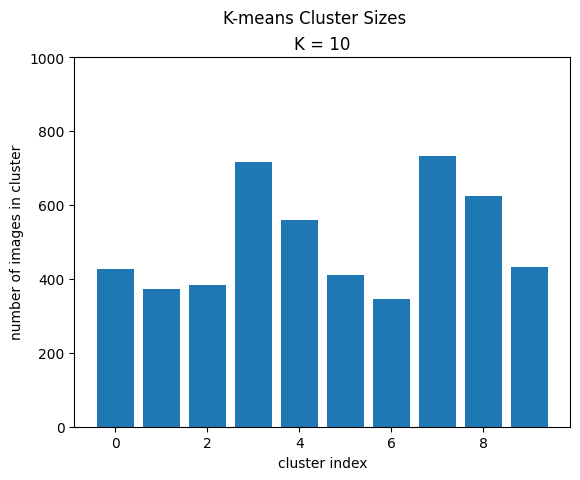

In [12]:
# K-means graphs
def plot_cluster_sizes(n_clusters, cluster_sizes, filename=None):
    fig, (ax) = plt.subplots(1, 1)
    fig.suptitle("K-means Cluster Sizes")
    ax.set_ylabel('number of images in cluster')
    cluster_idxs = [i for i in range(n_clusters)]

    def plot_sizes_per_linkage(ax, sizes, k):
        ax.bar(cluster_idxs, sizes)
        ax.set_title(f'K = {k}')
        ax.set_xlabel('cluster index')
        ax.set_ylim(0, 1000)

    plot_sizes_per_linkage(ax, cluster_sizes, str(n_clusters))
    if filename:
        plt.savefig(f'img_output/{filename}') 
    plt.show()

plot_cluster_sizes(KMeansClassifier.K, KMeansClassifier.get_cluster_sizes(), filename='p2.5b.png')

### Part 6: Confusion Matrix

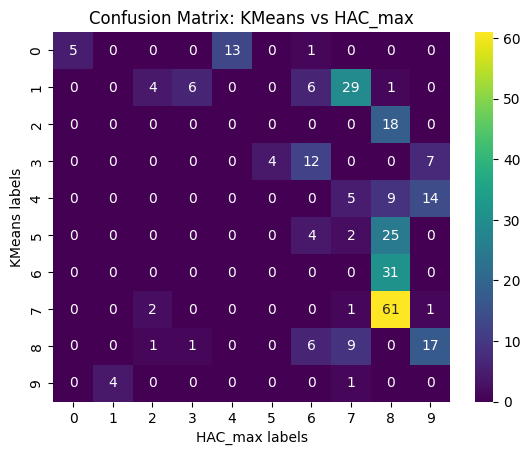

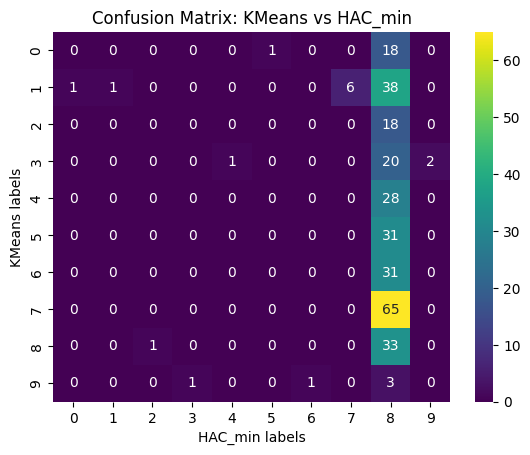

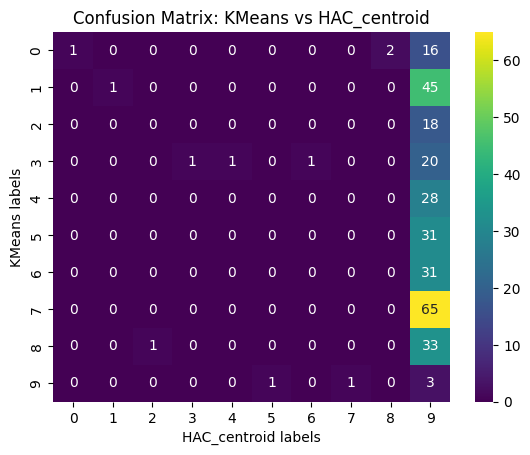

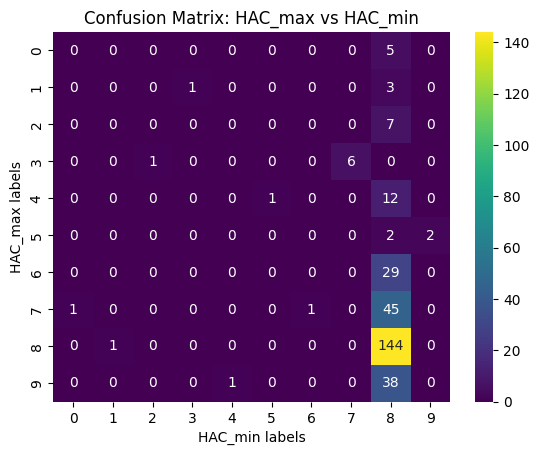

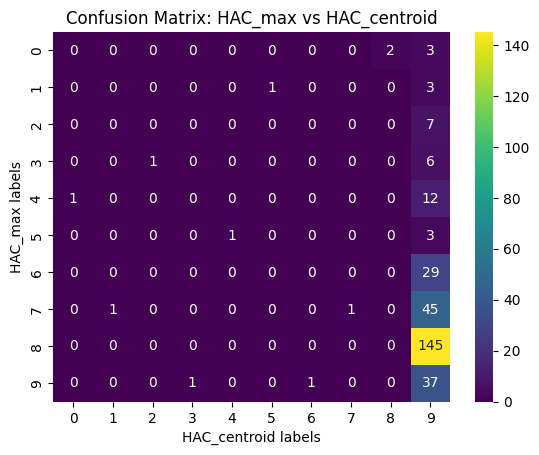

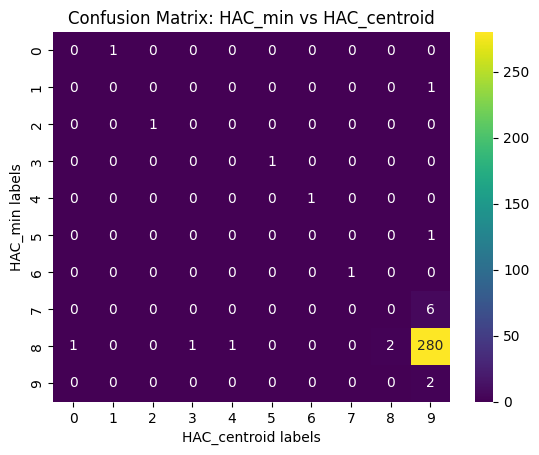

In [14]:
# Run K-means on small_dataset
kmeans_small = KMeans(K=10)
kmeans_small.fit(small_dataset)
kmeans_labels = kmeans_small.assignments

# Run HAC for each linkage on small_dataset
hac_labels = {}
for linkage in LINKAGES:
    hac_model = HAC(linkage)
    hac_model.fit(small_dataset)
    clusters = hac_model.get_k_clusters(10)
    labels = -1 * np.ones(small_dataset.shape[0], dtype=int)
    for label, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = label
    hac_labels[linkage] = labels

# Function to compute confusion matrix between two cluster labelings
def confusion_matrix(labels1, labels2, K=10):
    cm = np.zeros((K, K), dtype=int)
    for i in range(K):
        for j in range(K):
            cm[i, j] = np.sum((labels1 == i) & (labels2 == j))
    return cm

import seaborn as sns

methods = {'KMeans': kmeans_labels}
for linkage in LINKAGES:
    methods[f'HAC_{linkage}'] = hac_labels[linkage]

method_names = list(methods.keys())
for i in range(len(method_names)):
    for j in range(i + 1, len(method_names)):
        m1 = method_names[i]
        m2 = method_names[j]
        cm = confusion_matrix(methods[m1], methods[m2])
        plt.figure()
        sns.heatmap(cm, annot=True, fmt="d", cmap='viridis')
        plt.title(f'Confusion Matrix: {m1} vs {m2}')
        plt.xlabel(f'{m2} labels')
        plt.ylabel(f'{m1} labels')
        plt.show()
